# Zoolog

Zoolog, penguen türlerini tanıma konusunda uzmandır. Uzmanımızın adlandırabildiği 3 penguen türü şunlardır:

<img src='https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/01-Fundamentals-of-Machine-Learning/palmer-penguins.png' width=1000>

Peki siz onları ayırt edebiliyor musunuz?


## Görev

Penguenler hakkında hiçbir şey bilmediğimiz için, bu penguenleri özelliklerine göre sınıflandırmak için bir Makine Öğrenimi algoritması kullanalım.

## Dataset’i yükleyin

Seaborn [Penguins dataset](https://github.com/mwaskom/seaborn-data/blob/master/penguins.csv)’ini bir DataFrame içine yükleyelim. İşleri kolaylaştırmak için `nans` değerlerinden kurtulun! Aşağıdaki çıktıyı elde etmelisiniz:

<img src='https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/01-Fundamentals-of-Machine-Learning/penguin-df.png' width=600>

In [2]:
import pandas as pd

df = pd.read_csv('penguins.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [16]:
df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [12]:
df.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [18]:
df = df.fillna({
    "bill_depth_mm": df["bill_depth_mm"].mean(),
    "bill_length_mm": df["bill_length_mm"].mean(),
    "flipper_length_mm": df["flipper_length_mm"].mean(),
    "body_mass_g": df["body_mass_g"].mean(),
    "sex": df["sex"].mode()[0]
})
df.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

❓Penguenlerin özellikleri nelerdir?

<img src='https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/gentoo.png' width=700>

❓Bu veri setinde kaç tür penguen var?

In [20]:
df['species'].nunique()

3

❓Veri setinde her tür için kaç gözlem var?

In [21]:
df['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

##  Veri görselleştirme (Data visualization)

‘bill_length_mm’ değerini ‘bill_depth_mm’ değerine göre, her tür için farklı bir renk kullanarak grafikte gösterin:

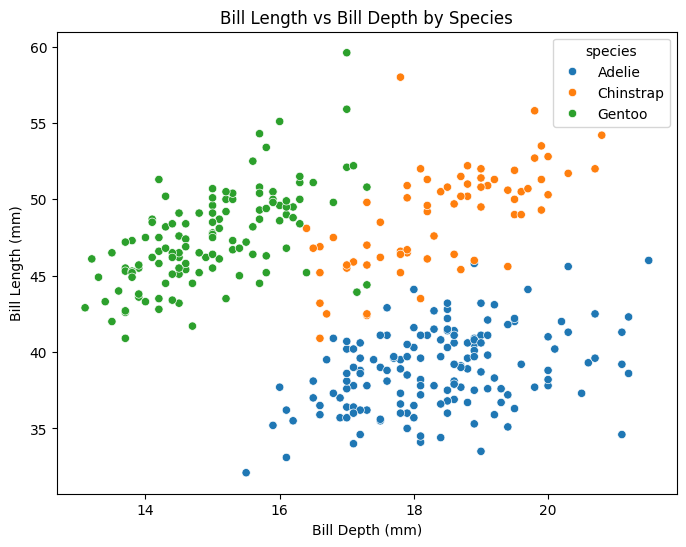

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="bill_depth_mm",
    y="bill_length_mm",
    hue="species"
)

plt.title("Bill Length vs Bill Depth by Species")
plt.xlabel("Bill Depth (mm)")
plt.ylabel("Bill Length (mm)")
plt.show()


❓Gözlemlerinize dayanarak bu türleri ayırt edebiliyor musunuz?

**gentoo** türü, diğer 2 türe göre açıkça daha uzun yüzgeçlere sahip gibi görünüyor.

## Modelleme

Çoklu sınıf sorununu çözmek için iki strateji vardır:

- Bire bir (One vs One)
- Bire tüm (Bire geri kalan)(One vs All)


### One vs One
- Dataset içindeki **her bir sınıf çifti için bir model** eğitilir
- Tahmin aşamasında, **en fazla oyu alan sınıf** seçilir

<img src='images/ovo_multiclass.png' width=500 style='margin:auto'> 


👍 Sınıf çiftlerine özgü farkları dikkate alır


👎 Çok sayıda alt model oluşturur: hesaplama açısından maliyetlidir


### One vs Rest (One vs All)

- **Her bir sınıf için**, diğer tüm sınıflara karşı **tek bir model** eğitilir
- Tahmin aşamasında, **en yüksek olasılığa sahip sınıf** seçilir

<img src='images/ova_multiclass.png' width=500 style='margin:auto'> 

👍 Hesaplama açısından daha az maliyetlidir


👎 Sınıfların bir araya getirilmesiyle, sınıf çiftlerine özgü farklar kaybolur ve etkileri azalır

In [25]:
df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

## One vs Rest

👇 Penguen türünü **sayısal (numerical)** feature’lara göre tahmin eden bir modeli değerlendirin. scikit-learn içinde, temel model olarak LogisticRegression kullanan bir One vs Rest multi-class classification uygulamak için doğru classifier’ı bulun. Modeli cross-validation ile değerlendirin ve bunun ne kadar süre aldığını kaydedin.

In [29]:
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

X = df[["bill_depth_mm", "bill_length_mm", "flipper_length_mm", "body_mass_g"]]
y = df["species"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_onevsrest = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", OneVsRestClassifier(
        LogisticRegression(max_iter=1000, random_state=42)
    ))
])

out_ovr = cross_validate(
    pipe_onevsrest, X, y,
    cv=cv,
    scoring="accuracy",
    return_train_score=False
)

print("=== One-vs-Rest (OvR) ===")
print("Test accuracy scores:", out_ovr["test_score"])
print("Mean accuracy:", out_ovr["test_score"].mean().round(4))
print("Std:", out_ovr["test_score"].std().round(4))
print("Mean fit_time (sec):", out_ovr["fit_time"].mean())
print("Mean score_time (sec):", out_ovr["score_time"].mean())
print("Total mean time/fold (sec):", (out_ovr["fit_time"] + out_ovr["score_time"]).mean())

=== One-vs-Rest (OvR) ===
Test accuracy scores: [0.97101449 0.97101449 0.98550725 0.95652174 1.        ]
Mean accuracy: 0.9768
Std: 0.0148
Mean fit_time (sec): 0.012220621109008789
Mean score_time (sec): 0.0027914524078369142
Total mean time/fold (sec): 0.015012073516845702


## One vs One

👇 Bu sefer bir `OneVsOneClassifier` implement edin.

Yine cross-validation ile değerlendirin ve bunun ne kadar süre aldığını kaydedin.

In [28]:
pipe_onevsone = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", OneVsOneClassifier(
        LogisticRegression(max_iter=1000, random_state=42)
    ))
])

out_ovo = cross_validate(
    pipe_onevsone, X, y,
    cv=cv,
    scoring="accuracy",
    return_train_score=False
)

print("\n=== One-vs-One (OvO) ===")
print("Test accuracy scores:", out_ovo["test_score"])
print("Mean accuracy:", out_ovo["test_score"].mean().round(4))
print("Std:", out_ovo["test_score"].std().round(4))
print("Mean fit_time (sec):", out_ovo["fit_time"].mean())
print("Mean score_time (sec):", out_ovo["score_time"].mean())
print("Total mean time/fold (sec):", (out_ovo["fit_time"] + out_ovo["score_time"]).mean())



=== One-vs-One (OvO) ===
Test accuracy scores: [0.97101449 0.97101449 0.98550725 0.95652174 1.        ]
Mean accuracy: 0.9768
Std: 0.0148
Mean fit_time (sec): 0.011039543151855468
Mean score_time (sec): 0.0032999515533447266
Total mean time/fold (sec): 0.014339494705200195


ℹ️ Her iki modelin de çok benzer doğruluklara sahip olduğunu görüyoruz. Neden? <br><br>
Öncelikle, her iki model de sınıflandırması görece kolay olan bir dataset üzerinde oldukça iyi bir performans sergiliyor. İkinci olarak, ayırt edilmesi gereken yalnızca üç sınıf olduğunda, hem OvO hem de OvR yaklaşımları aslında **3 adet alt modelin** eğitilmesiyle sonuçlanır! Bu nedenle, çok benzer doğruluklar elde etmemiz beklenir.

❓ Zoolog, 10 denemenin 9’unda doğru türü bulabiliyor; siz onu geçebilir misiniz?

<details>
<summary> 👉Çözüm </summary>
Yaklaşık %98’lik bir ortalama doğruluk elde etmelisiniz; bu da %90’dan daha yüksektir. Yani algoritmamız zoologu geçiyor!

</details>

# 🏁 